In [1]:
%matplotlib inline

In [2]:
import os
print("Current working directory: {0}".format(os.getcwd()))

Current working directory: /home/p22g5/AnomaliesRecycling/notebooks


In [3]:
#os.chdir('AnomaliesRecycling')
os.chdir('..')
print("Current working directory: {0}".format(os.getcwd()))

Current working directory: /home/p22g5/AnomaliesRecycling



Transfer Learning
==============================================
Based on this [tutorial](https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html#load-data)


In [4]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler

import torchvision
from torchvision import models, transforms
import matplotlib.pyplot as plt

from src.transfer_learning import TransferLearningTrainer
from src.cam import CAM


plt.ion()   # interactive mode

In [5]:
torch.cuda.is_available()
torch.cuda.current_device()
torch.cuda.device_count()

1

Load Data and Data Augmentation
---------

In [6]:
# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        transforms.ToPILImage(),
        transforms.Resize((256, 256)),
        transforms.RandomHorizontalFlip(p=0.5),
        #transforms.RandomVerticalFlip(p=0.5),
        #transforms.RandomRotation(degrees=(0, 180)),
        #transforms.ColorJitter(brightness=0.5, contrast=0.5, saturation=0.5, hue=0.2),
        #transforms.RandomSolarize(threshold=0.5),
        #transforms.RandomAdjustSharpness(sharpness_factor=50, p=0.5),

        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.ToPILImage(),
        transforms.Resize((256, 256)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

In [7]:
transferLearningTrainer = TransferLearningTrainer(data_transforms=data_transforms)

Visualize a few images



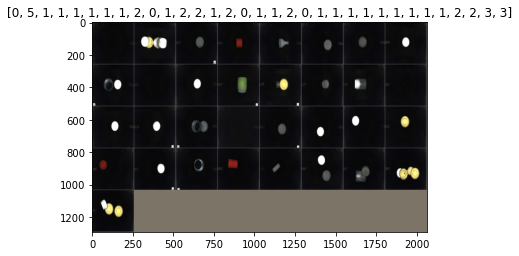

In [8]:
# Get a batch of training data
sample = next(iter(transferLearningTrainer.dataloaders['train']))
inputs, classes = sample['image'], sample['label']
# Make a grid from batch
out = torchvision.utils.make_grid(inputs)
transferLearningTrainer.imshow(out, [transferLearningTrainer.class_names[x] for x in classes])

Training the model
------------------

Finetuning the convnet
----------------------

Load a pretrained model and reset final fully connected layer.




In [9]:
model_name = "test"
model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features
# Here the size of each output sample is set to 6, since we have 6 classes
model_ft.fc = nn.Linear(num_ftrs, len(transferLearningTrainer.class_names))
criterion = nn.CrossEntropyLoss()
# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=10, gamma=0.1)

 ***Train and evaluate***

In [10]:
model_ft = transferLearningTrainer.train_model(model=model_ft,
                                               criterion=criterion,
                                               optimizer=optimizer_ft,
                                               scheduler=exp_lr_scheduler,
                                               num_epochs=10,
                                               model_name=model_name,
                                               early_stop=False)

Epoch 0/9
----------
train Loss: 0.5619 Acc: 0.7957 MAE: 0.2404 MAPE: nan MSE: 0.3295 R^2: 0.5487
test Loss: 0.4162 Acc: 0.8544 MAE: 0.1562 MAPE: nan MSE: 0.1802 R^2: 0.7500

Epoch 1/9
----------
train Loss: 0.2475 Acc: 0.9179 MAE: 0.0859 MAPE: nan MSE: 0.0934 R^2: 0.8720
test Loss: 0.3177 Acc: 0.8904 MAE: 0.1156 MAPE: nan MSE: 0.1276 R^2: 0.8229

Epoch 2/9
----------
train Loss: 0.1679 Acc: 0.9449 MAE: 0.0573 MAPE: nan MSE: 0.0618 R^2: 0.9153
test Loss: 0.3487 Acc: 0.8889 MAE: 0.1126 MAPE: nan MSE: 0.1156 R^2: 0.8396

Epoch 3/9
----------
train Loss: 0.1278 Acc: 0.9602 MAE: 0.0404 MAPE: nan MSE: 0.0415 R^2: 0.9431
test Loss: 0.2669 Acc: 0.9114 MAE: 0.0916 MAPE: nan MSE: 0.0976 R^2: 0.8646

Epoch 4/9
----------
train Loss: 0.0925 Acc: 0.9716 MAE: 0.0293 MAPE: nan MSE: 0.0312 R^2: 0.9573
test Loss: 0.2787 Acc: 0.9099 MAE: 0.0931 MAPE: nan MSE: 0.0991 R^2: 0.8625

Epoch 5/9
----------
train Loss: 0.0700 Acc: 0.9795 MAE: 0.0207 MAPE: nan MSE: 0.0211 R^2: 0.9712
test Loss: 0.2325 Acc: 0.91

/cvhci/temp/p22g5/data/cluttered/Anlerndaten (168).jpg


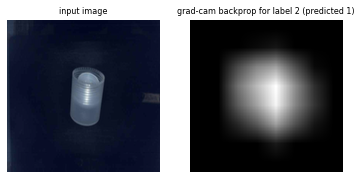

In [11]:
model_name += "_weights.pth"
model_ft = models.resnet18()
num_ftrs = model_ft.fc.in_features
# Here the size of each output sample is set to 6, since we have 6 classes
model_ft.fc = torch.nn.Linear(num_ftrs, len(transferLearningTrainer.class_names))
model_ft.load_state_dict(torch.load(transferLearningTrainer.MODELS_DIR + model_name))
# print(model_ft)

cam = CAM(transferLearningTrainer)
cam.print_cam(model_ft)

In [ ]:
!reload_ext tensorboard
!tensorboard --logdir /cvhci/temp/p22g5/runs/

***Filenames where validation failed***

In [11]:
_ = transferLearningTrainer.print_misclassified(model_ft, plot=True)

cluttered/Anlerndaten (830).jpg
must be 2, but predicted 1
cluttered/Anlerndaten (460).jpg
must be 3, but predicted 2
harder_samples/Anlernbilder (154).jpg
must be 5, but predicted 4
harder_samples/Anlernbilder (338).jpg
must be 3, but predicted 2
cluttered/Anlerndaten (875).jpg
must be 2, but predicted 1
cluttered/Anlerndaten (161).jpg
must be 2, but predicted 1
harder_samples/Anlernbilder (171).jpg
must be 3, but predicted 2
presorted/trial (127).jpg
must be 2, but predicted 1
cluttered/Anlerndaten (764).jpg
must be 1, but predicted 0
cluttered/Anlerndaten (615).jpg
must be 2, but predicted 1
cluttered/Anlerndaten (465).jpg
must be 3, but predicted 2
harder_samples/Anlernbilder (193).jpg
must be 3, but predicted 2
harder_samples/Anlernbilder (149).jpg
must be 3, but predicted 2
presorted/trial (1326).jpg
must be 2, but predicted 1
harder_samples/Anlernbilder (362).jpg
must be 4, but predicted 2
harder_samples/Anlernbilder (88).jpg
must be 3, but predicted 2
harder_samples/Anlernbilde

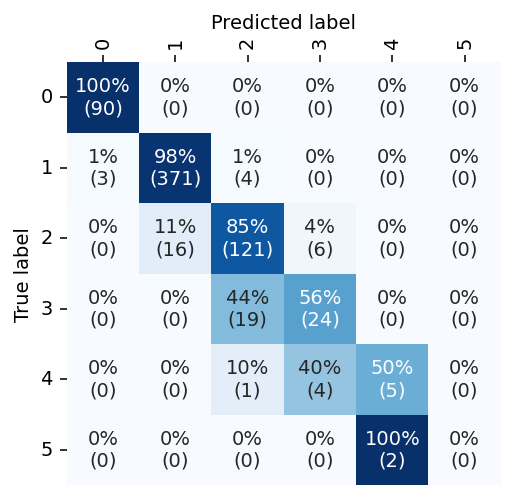

In [21]:
transferLearningTrainer.print_confusion_matrix(model_ft)

ConvNet as fixed feature extractor
----------------------------------

In [ ]:
model_name = "ResNet18_test"
model_conv = torchvision.models.resnet18(pretrained=True)
for param in model_conv.parameters():
    param.requires_grad = False
# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, len(transferLearningTrainer.class_names))
criterion = nn.CrossEntropyLoss()
# Observe that only parameters of final layer are being optimized as
# opposed to before.
optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)
# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

Train and evaluate
^^^^^^^^^^^^^^^^^^

On CPU this will take about half the time compared to previous scenario.
This is expected as gradients don't need to be computed for most of the
network. However, forward does need to be computed.




In [ ]:
model_conv = transferLearningTrainer.train_model(model_conv,
                                                 criterion,
                                                 optimizer_conv,
                                                 exp_lr_scheduler,
                                                 num_epochs=50,
                                                 model_name=model_name)

In [ ]:
transferLearningTrainer.visualize_model(model_conv)